In [1]:
import numpy as np
from scipy.optimize import curve_fit
from utils import sample_observed_data_berkson, sample_observed_data_classical

In [2]:
confidence_level = 0.90
num_realizations = 100
seed = 112
folder_path = '/dcs/pg23/u1604520/mem/results/exponential_classical_unifstart/new/'
folder_path_simex = folder_path+'simex/exponential_classical_unifstart/'

In [3]:
scales_nu = [0.000001, 0.5,  1.0, 2.0] #, 2.0]
num_scales = len(scales_nu)
c = 100
n = 200
B = 500
theta_star = np.array([1,2]) 
loc_x = 0
scale_x = 1
scale_eps = 0.5
num_methods = 3

In [4]:
def reg_func(theta,x):
    return (np.exp(theta[0] + theta[1]*x))/(1 + np.exp(theta[0] + theta[1]*x))

In [5]:
def nonlinear_model(x, a, b):
    return (np.exp(a + b*x))/(1 + np.exp(a + b*x)) #a + b*x + c*x**2

In [30]:
mses = np.zeros((num_scales, num_realizations, num_methods, len(theta_star)))
stds = np.zeros((num_scales, num_realizations, num_methods, len(theta_star)))
counts = np.zeros((num_scales, len(theta_star)))
coverage_probabilities = np.zeros((num_scales, len(theta_star)))
for j, scale_nu in enumerate(scales_nu):
    seed1 = 12
    seed2 = 112
    seed = 12
    for r in range(num_realizations):
        seed2 += 1
        seed1 += 1
        seed += 1
        boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed1{seed1}_seed2{seed2}.txt')
        if scale_nu == 1.0:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{1}_seed{seed}.txt')
        elif scale_nu == 2.0:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{2}_seed{seed}.txt')
        else:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{scale_nu}_seed{seed}.txt')
        data, x = sample_observed_data_classical(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed1)#np.loadtxt(folder_path+f'data_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        mean_boot_sample = boot_sample.mean(axis=0)
        #mean_simex_sample = simex_sample.mean(axis=0)
        initial_guess = np.random.uniform(low=-1, high=4, size=(2,)) #[0, 4]  # Initial parameter guess
        ls_estimator, _ = curve_fit(nonlinear_model, data[:,0], data[:,1], p0=initial_guess)
        mses[j, r, 0, :] = np.asarray((mean_boot_sample - theta_star)**2)
        mses[j, r, 1, :] = np.asarray((simex_sample - theta_star)**2)
        mses[j, r, 2, :] = np.asarray((ls_estimator - theta_star)**2)

        # Credible interval 
        for i in range(len(theta_star)):
            count = 0
            lower_bound = np.percentile(boot_sample[:, i], (1 - confidence_level) / 2 * 100)
            upper_bound = np.percentile(boot_sample[:, i], (1 + confidence_level) / 2 * 100)
            if lower_bound <= theta_star[i] <= upper_bound:
                count += 1
            counts[j, i] += count
            
    # Calculate the coverage probability
    coverage_probabilities[j, :] = counts[j, :] / num_realizations
    mses_over_runs = np.mean(mses, axis=1)
    stds_mses_over_runs = np.std(mses, axis=1)
        
    print(f"Coverage Probability for theta_1 for ME std {scale_nu}: {coverage_probabilities[j, 0] * 100}%")
    print(f"Coverage Probability for theta_2 for ME std {scale_nu}: {coverage_probabilities[j, 1] * 100}%")
    #print(f"Coverage Probability for theta_3 for ME std {scale_nu}: {coverage_probabilities[2] * 100}%")
    print(f"Mean Squared error for Robust-MEM: {mses_over_runs[j, 0, :]}")
    print(f"Mean Squared error for SIMEX: {mses_over_runs[j, 1, :]}")
    print(f"Mean Squared error for Least Squares: {mses_over_runs[j, 2, :]}")
    print(f"Std - Mean Squared error for Robust-MEM: {stds_mses_over_runs[j, 0, :]}")
    print(f"Std - Mean Squared error for SIMEX: {stds_mses_over_runs[j, 1, :]}")
    print(f"Std - Mean Squared error for Least Squares: {stds_mses_over_runs[j, 2, :]}")

Coverage Probability for theta_1 for ME std 1e-06: 96.0%
Coverage Probability for theta_2 for ME std 1e-06: 100.0%
Mean Squared error for Robust-MEM: [0.10010042 0.0585897 ]
Mean Squared error for SIMEX: [0.09632831 0.26430582]
Mean Squared error for Least Squares: [0.09632365 0.26427517]
Std - Mean Squared error for Robust-MEM: [0.11684052 0.07833864]
Std - Mean Squared error for SIMEX: [0.17866025 0.55164394]
Std - Mean Squared error for Least Squares: [0.17860985 0.5514423 ]
Coverage Probability for theta_1 for ME std 0.5: 97.0%
Coverage Probability for theta_2 for ME std 0.5: 100.0%
Mean Squared error for Robust-MEM: [0.10119932 0.05633915]
Mean Squared error for SIMEX: [0.11090373 0.32334805]
Mean Squared error for Least Squares: [0.07702771 0.38496102]
Std - Mean Squared error for Robust-MEM: [0.11836142 0.07925495]
Std - Mean Squared error for SIMEX: [0.20163872 0.66284626]
Std - Mean Squared error for Least Squares: [0.09256247 0.31392922]
Coverage Probability for theta_1 for M

### Make a table

In [31]:
import pandas as pd

Coverage probabilities for Robust MEM

In [32]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    data_coverage = {'Param': ['$\theta_1$', '$\theta_2$'], 'Coverage prob.': coverage_probabilities[i, :], '$\sigma_\nu$': scale_nu}
    df = pd.DataFrame(data_coverage)
    dfs.append(df)
cov_df = pd.concat(dfs, ignore_index=True)
cov_gb = cov_df.groupby((['Param', '$\sigma_\nu$'])).mean()
pivot_cov = cov_gb.pivot_table(index=['Param'], columns='$\sigma_\nu$', values=['Coverage prob.'])
pivot_cov

Coverage prob.                           
$\sigma_
u$       0.000001 0.500000 1.000000 2.000000
Param                                                
$\theta_1$            0.96     0.97     0.98     0.98
$\theta_2$            1.00     1.00     1.00     1.00

MSE and STD

In [33]:
def create_dataframe(mse_array, std_array, scale_nu, method_name):
    
    data = {'Param': ['$\theta_1$', '$\theta_2$'], 'MSE': mse_array, 'Std': std_array, '$\sigma_\nu$': scale_nu, 'Method': [method_name]*len(mse_array)}
    df = pd.DataFrame(data)
    
    return df

In [34]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,0,:], stds_mses_over_runs[i,0,:], scale_nu, 'Robust-MEM (MMD)')
    dfs.append(df)
robustmem_df = pd.concat(dfs, ignore_index=True)

In [35]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,1,:], stds_mses_over_runs[i,1,:], scale_nu, 'SIMEX')
    dfs.append(df)
simex_df = pd.concat(dfs, ignore_index=True)

In [36]:
dfs = []
for i, scale_nu in enumerate(scales_nu):
    df = create_dataframe(mses_over_runs[i,2,:], stds_mses_over_runs[i,2,:], scale_nu, 'LS')
    dfs.append(df)
ls_df = pd.concat(dfs, ignore_index=True)

In [37]:
df_all = pd.concat([robustmem_df, simex_df, ls_df])

In [38]:
df_all

,Param,MSE,Std,$\sigma_\nu$,Method
0,$\theta_1$,0.100100,0.116841,0.000001,Robust-MEM (MMD)
1,$\theta_2$,0.058590,0.078339,0.000001,Robust-MEM (MMD)
2,$\theta_1$,0.101199,0.118361,0.500000,Robust-MEM (MMD)
3,$\theta_2$,0.056339,0.079255,0.500000,Robust-MEM (MMD)
4,$\theta_1$,0.105708,0.122270,1.000000,Robust-MEM (MMD)
5,$\theta_2$,0.057701,0.086861,1.000000,Robust-MEM (MMD)
6,$\theta_1$,0.112603,0.128212,2.000000,Robust-MEM (MMD)
7,$\theta_2$,0.060378,0.089540,2.000000,Robust-MEM (MMD)
0,$\theta_1$,0.096328,0.178660,0.000001,SIMEX
1,$\theta_2$,0.264306,0.551644,0.000001,SIMEX


In [39]:
gb = df_all.groupby(['Method', 'Param', '$\sigma_\nu$']).mean()

In [40]:
pivot_df = gb.pivot_table(index=['Method', 'Param'], columns='$\sigma_\nu$', values=['MSE','Std'])

# Flatten the MultiIndex columns
pivot_df.columns = [f'{col[0]}-{col[1]}' for col in pivot_df.columns]

cols = pivot_df.columns.tolist()
mse_cols = [col for col in cols if 'MSE' in col]
std_cols = [col for col in cols if 'Std' in col]
rearranged_cols = [item for pair in zip(mse_cols, std_cols) for item in pair]
pivot_df = pivot_df[rearranged_cols]

# Reset index to make 'method' and 'param' regular columns
pivot_df.reset_index(inplace=True)
pivot_df

,Method,Param,MSE-1e-06,Std-1e-06,MSE-0.5,Std-0.5,MSE-1.0,Std-1.0,MSE-2.0,Std-2.0
0,LS,$\theta_1$,0.096324,0.178610,0.077028,0.092562,0.118299,0.201427,0.138541,0.127237
1,LS,$\theta_2$,0.264275,0.551442,0.384961,0.313929,1.454970,0.490646,2.926154,0.359771
2,Robust-MEM (MMD),$\theta_1$,0.100100,0.116841,0.101199,0.118361,0.105708,0.122270,0.112603,0.128212
3,Robust-MEM (MMD),$\theta_2$,0.058590,0.078339,0.056339,0.079255,0.057701,0.086861,0.060378,0.089540
4,SIMEX,$\theta_1$,0.096328,0.178660,0.110904,0.201639,0.261294,1.562083,0.129625,0.126831
5,SIMEX,$\theta_2$,0.264306,0.551644,0.323348,0.662846,0.747823,1.019098,2.244498,0.575986


In [41]:
pivot_df = pivot_df.groupby(['Method', 'Param']).mean()
pivot_df

MSE-1e-06  Std-1e-06   MSE-0.5   Std-0.5  \
Method           Param                                                  
LS               $\theta_1$   0.096324   0.178610  0.077028  0.092562   
                 $\theta_2$   0.264275   0.551442  0.384961  0.313929   
Robust-MEM (MMD) $\theta_1$   0.100100   0.116841  0.101199  0.118361   
                 $\theta_2$   0.058590   0.078339  0.056339  0.079255   
SIMEX            $\theta_1$   0.096328   0.178660  0.110904  0.201639   
                 $\theta_2$   0.264306   0.551644  0.323348  0.662846   

                              MSE-1.0   Std-1.0   MSE-2.0   Std-2.0  
Method           Param                                               
LS               $\theta_1$  0.118299  0.201427  0.138541  0.127237  
                 $\theta_2$  1.454970  0.490646  2.926154  0.359771  
Robust-MEM (MMD) $\theta_1$  0.105708  0.122270  0.112603  0.128212  
                 $\theta_2$  0.057701  0.086861  0.060378  0.089540  
SIMEX            $\theta_1$  0.261294  1.562083  0.129625  0.126831  
                 $\theta_2$  0.747823  1.019098  2.244498  0.575986

In [42]:
new_df = pivot_df.copy(deep=True)
nus = [1e-06, 0.5, 1.0, 2.0]
# Iterate over columns
for i, nu in enumerate(nus):  # Assuming you have two pairs a_i and b_i
    # Extract corresponding pairs
    a_col = f'MSE-{nu}'
    b_col = f'Std-{nu}'
    # Concatenate values for the title
    new_df[f'$\sigma_\nu = {nu}$'] = pivot_df[a_col].round(3).astype(str) + ' ' + '(' + pivot_df[b_col].round(3).astype(str) + ')'
    new_df = new_df.drop(a_col, axis=1)
    new_df = new_df.drop(b_col, axis=1) 
    

new_df

$\sigma_\nu = 1e-06$ $\sigma_\nu = 0.5$  \
Method           Param                                                
LS               $\theta_1$        0.096 (0.179)      0.077 (0.093)   
                 $\theta_2$        0.264 (0.551)      0.385 (0.314)   
Robust-MEM (MMD) $\theta_1$          0.1 (0.117)      0.101 (0.118)   
                 $\theta_2$        0.059 (0.078)      0.056 (0.079)   
SIMEX            $\theta_1$        0.096 (0.179)      0.111 (0.202)   
                 $\theta_2$        0.264 (0.552)      0.323 (0.663)   

                            $\sigma_\nu = 1.0$ $\sigma_\nu = 2.0$  
Method           Param                                             
LS               $\theta_1$      0.118 (0.201)      0.139 (0.127)  
                 $\theta_2$      1.455 (0.491)       2.926 (0.36)  
Robust-MEM (MMD) $\theta_1$      0.106 (0.122)      0.113 (0.128)  
                 $\theta_2$      0.058 (0.087)        0.06 (0.09)  
SIMEX            $\theta_1$      0.261 (1.562)       0.13 (0.127)  
                 $\theta_2$      0.748 (1.019)      2.244 (0.576)

In [43]:
latex_table =new_df.to_latex()
print(latex_table)

\begin{tabular}{llllll}
\toprule
 &  & $\sigma_
u = 1e-06$ & $\sigma_
u = 0.5$ & $\sigma_
u = 1.0$ & $\sigma_
u = 2.0$ \\
Method & Param &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{LS} & $	heta_1$ & 0.096 (0.179) & 0.077 (0.093) & 0.118 (0.201) & 0.139 (0.127) \\
 & $	heta_2$ & 0.264 (0.551) & 0.385 (0.314) & 1.455 (0.491) & 2.926 (0.36) \\
\cline{1-6}
\multirow[t]{2}{*}{Robust-MEM (MMD)} & $	heta_1$ & 0.1 (0.117) & 0.101 (0.118) & 0.106 (0.122) & 0.113 (0.128) \\
 & $	heta_2$ & 0.059 (0.078) & 0.056 (0.079) & 0.058 (0.087) & 0.06 (0.09) \\
\cline{1-6}
\multirow[t]{2}{*}{SIMEX} & $	heta_1$ & 0.096 (0.179) & 0.111 (0.202) & 0.261 (1.562) & 0.13 (0.127) \\
 & $	heta_2$ & 0.264 (0.552) & 0.323 (0.663) & 0.748 (1.019) & 2.244 (0.576) \\
\cline{1-6}
\bottomrule
\end{tabular}



Plot

In [44]:
def lighten_color(color, amount=0.5):
    """
    From: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [45]:
pip install seaborn

/dcs/pg23/u1604520/.conda/envs/mem-env/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


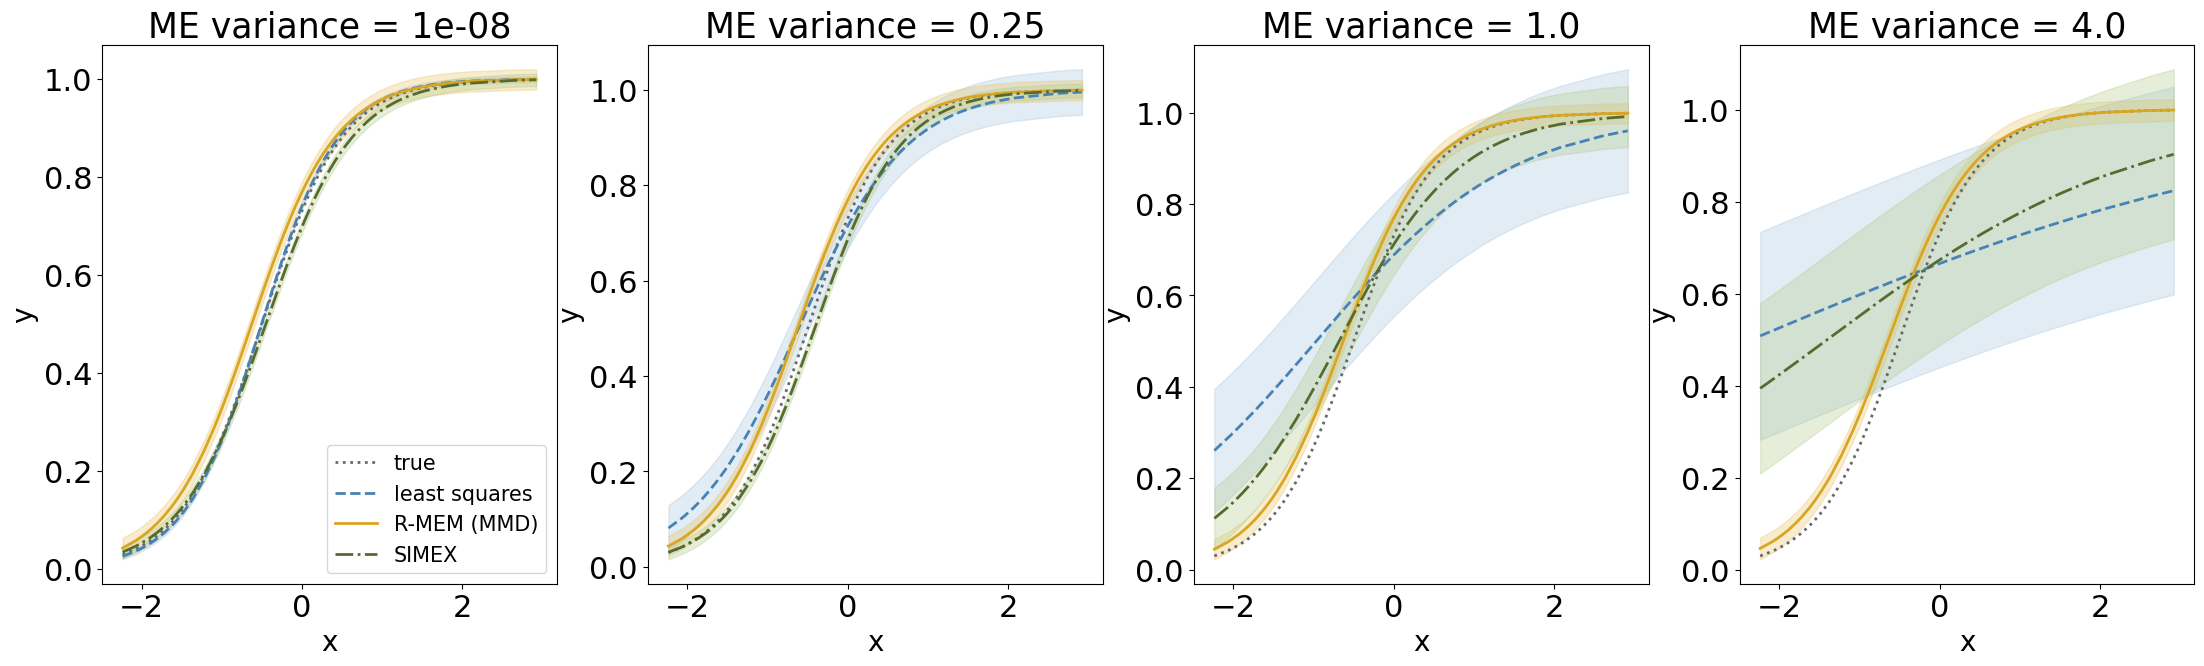

In [67]:
import matplotlib.pyplot as plt
num_methods = 3
num_realizations = 100
num_scales = len(scales_nu)
fig, ax_array = plt.subplots(1, num_scales, figsize=(27,7))
credible_interval = 0.90
n = 200
regs = np.zeros((num_realizations, num_methods, n))
lower_bounds = np.zeros((num_methods, n))
upper_bounds = np.zeros((num_methods, n))
std_error = np.zeros(num_methods)
means = np.zeros((num_methods, n))
for ax, j in zip(ax_array.flatten(), range(0, num_scales)):
    scale_nu = scales_nu[j]
    seed1 = 12
    seed2 = 112
    thetas_over_run = np.zeros((len(theta_star), num_methods, num_realizations))
    for r in range(num_realizations):
        seed1 += 1
        seed2 += 1
        boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed1{seed1}_seed2{seed2}.txt')
        if scale_nu == 1.0:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{1}_seed{seed1}.txt')
        elif scale_nu == 2.0:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{2}_seed{seed1}.txt')
        else:
            simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{scale_nu}_seed{seed}.txt')
        data, xis_star = sample_observed_data_classical(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed1)#np.loadtxt(folder_path+f'data_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
        mean_boot_sample = boot_sample.mean(axis=0)
        initial_guess = np.random.uniform(low=-1, high=4, size=(2,)) #[0, 4]  # Initial parameter guess
        ls_estimator, _ = curve_fit(nonlinear_model, data[:,0], data[:,1], p0=initial_guess)
        thetas_over_run[:, 0, r] = mean_boot_sample
        thetas_over_run[:, 1, r] = simex_sample
        thetas_over_run[:, 2, r] = ls_estimator
        # xis_star_sorted = np.sort(xis_star)
        # regs[r,0,:] = reg_func(thetas_over_run[:,0,r], xis_star_sorted)
        # regs[r,1,:] = reg_func(thetas_over_run[:,1,r], xis_star_sorted)
        # regs[r,2,:] = reg_func(thetas_over_run[:,2,r], xis_star_sorted)
        
    # test data
    data, xis_star = sample_observed_data_classical(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, 300)
    xis_star_sorted = np.sort(xis_star)
    Y_real = reg_func(theta_star, xis_star_sorted)
    means[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1), xis_star_sorted)
    residuals = np.array(Y_real) - means[0, :]
    std_error[0] = np.std(residuals, axis=0)
    lower_bounds[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1) - thetas_over_run[:,0,:].std(axis=1), xis_star_sorted)
    upper_bounds[0, :] = reg_func(thetas_over_run[:,0,:].mean(axis=1) + thetas_over_run[:,0,:].std(axis=1), xis_star_sorted)

    means[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1), xis_star_sorted)
    residuals = np.array(Y_real) - means[1, :]
    std_error[1] = np.std(residuals, axis=0)
    lower_bounds[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1) - thetas_over_run[:,1,:].std(axis=1), xis_star_sorted)
    upper_bounds[1, :] = reg_func(thetas_over_run[:,1,:].mean(axis=1) + thetas_over_run[:,1,:].std(axis=1), xis_star_sorted)

    means[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1), xis_star_sorted)
    residuals = np.array(Y_real) - means[2, :]
    std_error[2] = np.std(residuals, axis=0)
    lower_bounds[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1) - thetas_over_run[:,2,:].std(axis=1), xis_star_sorted)
    upper_bounds[2, :] = reg_func(thetas_over_run[:,2,:].mean(axis=1) + thetas_over_run[:,2,:].std(axis=1), xis_star_sorted)
    
    
    ax.plot(xis_star_sorted, Y_real, linestyle='dotted', label='true', color='dimgrey', lw=2)
    
    ax.plot(xis_star_sorted, means[2,:], linestyle='dashed', label='least squares', color='#4682B4', lw=2)
    #ax.fill_between(xis_star_sorted, lower_bounds[2, :], upper_bounds[2, :], color=lighten_color('#4682B4'), alpha=0.3)
    ax.fill_between(xis_star_sorted, means[2, :] - std_error[2], means[2, :] + std_error[2], color=lighten_color('#4682B4'), alpha=0.3)
    
    ax.plot(xis_star_sorted, means[0, :], linestyle='solid', label='R-MEM (MMD)', color='goldenrod',lw=2)
    #ax.fill_between(xis_star_sorted, lower_bounds[0, :], upper_bounds[0, :], color=lighten_color('goldenrod', 0.7), alpha=0.3)
    ax.fill_between(xis_star_sorted, means[0, :] - std_error[0], means[0, :] + std_error[0], color=lighten_color('goldenrod', 0.7), alpha=0.3)

    ax.plot(xis_star_sorted, means[1, :], linestyle='dashdot', label='SIMEX',color='#556B2F', lw=2)
    #ax.fill_between(xis_star_sorted, lower_bounds[1, :], upper_bounds[1, :], color=lighten_color('#556B2F'), alpha=0.3)
    ax.fill_between(xis_star_sorted, means[1, :] - std_error[1], means[1, :] + std_error[1], color=lighten_color('#556B2F'), alpha=0.3)
    
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)
    ax.patch.set_facecolor('white')
    if j == 0:
        ax.set_title(f'ME variance = 1e-08', fontsize=25)
    elif j == 1 or j == 3:
        ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)
    elif j == 2:
        ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)

    ax.set_xlabel('x',fontsize=20)
    ax.set_ylabel('y',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=22)
    if j == 0:
        ax.legend(fontsize=15)

### Palia

FileNotFoundError: /dcs/pg23/u1604520/mem/results/exponential_classical_unifstart/new/sample_scale_nu1e-06_c100_n200_B500_seed14.txt not found.

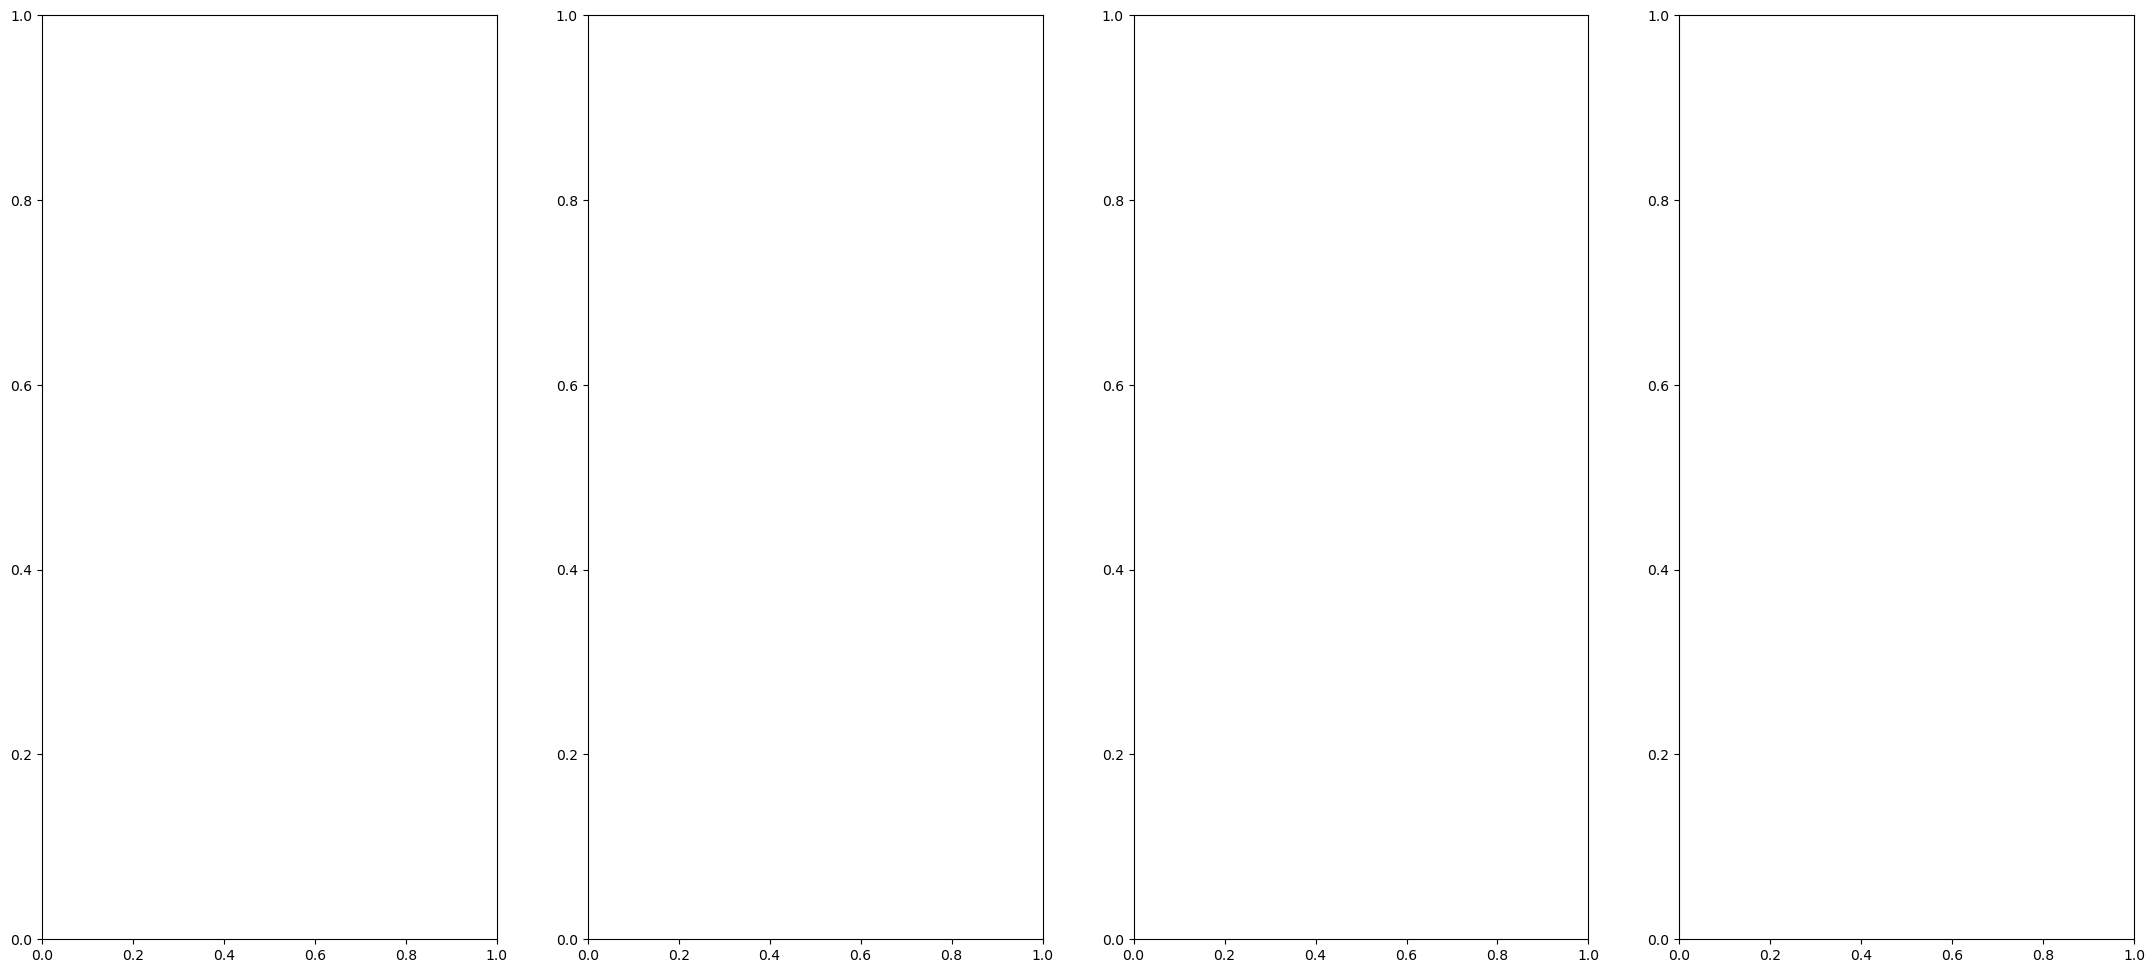

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

num_thetas = 2
scales_nu = [0.000001, 0.5,  1.0, 2.0] #, 2.0]
num_scales = len(scales_nu)
c = 100
n = 200
B = 500
theta_star = np.array([1,2]) 
loc_x = 0
scale_x = 1
scale_eps = 0.5
num_methods = 3
fig, ax_array = plt.subplots(1, num_scales, figsize=(27,12))
seed = 14

for ax, i in zip(ax_array.flatten(), range(0, num_scales)):
  scale_nu = scales_nu[i]
  boot_sample = np.loadtxt(folder_path+f'sample_scale_nu{scale_nu}_c{c}_n{n}_B{B}_seed{seed}.txt')
  thetas = np.mean(boot_sample, axis=0).flatten()
  if scale_nu == 1.0:
    simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{1}_seed{seed}.txt')
  elif scale_nu != 2.0 and scale_nu != 1.0:
    simex_sample = np.loadtxt(folder_path_simex+f'simex_scale_nu{scale_nu}_seed{seed}.txt')
  
  data, xis_star = sample_observed_data_classical(reg_func, int(n), loc_x, scale_x, scale_nu, scale_eps, theta_star, seed)
  initial_guess = [0,0] #[0, 4]  # Initial parameter guess
  ls_estimator, _ = curve_fit(nonlinear_model, data[:,0], data[:,1], p0=initial_guess)
  
  # # Credible intervals
  # credible_interval = 0.90
  # regs = np.zeros((B,len(xis_star)))
  # for b in range(B):
  #   regs[b,:] = reg_func(thetas_all[b,:], xis_star)
  # lower_bound = np.percentile(regs, (1 - credible_interval) / 2 * 100, axis=1)
  # upper_bound = np.percentile(regs, (1 + credible_interval) / 2 * 100, axis=1)
  

  Y = reg_func(thetas, xis_star)
  Y_real = reg_func(theta_star, xis_star)
  Y_ls = reg_func(ls_estimator, xis_star)
  Y_simex = reg_func(simex_sample, xis_star)

  ax.scatter(data[:,0],data[:,1], marker="x", label='observed data', color='cadetblue', alpha=0.4)
  ax.scatter(xis_star, data[:,1], marker = "o", label='real data', color=lighten_color('indianred',amount=0.8), alpha=0.4)

  x,y = sort_array(xis_star, Y_real)
  ax.plot(x,y, label='true', color='dimgrey', lw=5)
  x,y = sort_array(xis_star, Y_ls)
  ax.plot(x,y, label='least squares', color='#4682B4', lw=5)
  x,y = sort_array(xis_star, Y)
  ax.plot(x,y, label='R-MEM (MMD)', color='goldenrod',lw=5)
  if scale_nu != 2.0:
    x,y = sort_array(xis_star, Y_simex)
    ax.plot(x,y, label='SIMEX',color='#556B2F', lw=5)
  # ax.plot(xis_star,Y, label='R-MEM (MMD)', color='goldenrod',lw=6)
  #x,y1,y2 = sort_array2(xis_star, lower_bound, upper_bound)
  #ax.fill_between(x, y1, y2, color="pink", alpha=0.3, label=f"{credible_interval * 100}% Credible Intervals")
  ax.yaxis.grid(False)
  ax.xaxis.grid(False)
  ax.patch.set_facecolor('white')
  if i == 0:
    ax.set_title(f'ME variance = 1e-08', fontsize=25)
  elif i == 1 or i == 3:
    ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)
  elif i == 2:
    ax.set_title(f'ME variance = {scale_nu**2}', fontsize=25)

  ax.set_xlabel('x',fontsize=20)
  ax.set_ylabel('y',fontsize=20)
  ax.tick_params(axis='both', which='major', labelsize=22)
  ax.tick_params(axis='both', which='minor', labelsize=22)
  if i == 0:
    ax.legend(fontsize=20)

